In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Import data
data = pd.read_pickle("~/Downloads/integrated_draws_20_5_4.pkl")
n_draws, n_time, dim_X, dim_fac = data['beta'].shape
beta = data['beta']
X_sd = data['x_sd']

# Generate X
m_fac = np.zeros((dim_fac))
s_fac = np.diag(np.ones((dim_fac)))
fac = np.expand_dims(mvnorm(m_fac, s_fac, (n_draws, n_time)), -1)

X = np.matmul(beta, fac).squeeze()

m_eps = np.zeros((dim_X))
for i in range(n_draws):
    eps = mvnorm(m_eps, np.diag(X_sd[i] ** 2), n_time)
    X[i] += X[i] + eps
    
X = X.transpose((2, 0, 1))
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [27]:
from regain.covariance import InequalityTimeGraphicalLasso
tgl = InequalityTimeGraphicalLasso(max_iter=1000, loss='LL', c_level=0.25, rho=1e2, psi="laplacian")
emp_inv_score, baseline_score, fit_score, pre = tgl.fit_cov(X_cov).eval_cov_pre()    

/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/inequality_time_graphical_lasso.py:336: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [24]:
print(pre[50])

[[ 0.36019403 -0.02869601 -0.          0.         -0.         -0.
   0.          0.         -0.          0.02351051 -0.         -0.
   0.         -0.         -0.         -0.11832195 -0.         -0.0098967
  -0.         -0.        ]
 [-0.02869601  0.25463031  0.07612494  0.         -0.          0.
   0.          0.          0.          0.02221801 -0.01847752 -0.
   0.00508553 -0.          0.         -0.07364891 -0.          0.
  -0.          0.        ]
 [-0.          0.07612494  0.23066626 -0.         -0.          0.
  -0.05761468 -0.07695878  0.         -0.          0.00433535  0.
  -0.05831394  0.          0.         -0.04057323  0.         -0.03277207
   0.          0.00867617]
 [ 0.          0.         -0.          0.23125399 -0.          0.
   0.         -0.02321378  0.00880292 -0.         -0.06604376  0.
   0.         -0.         -0.          0.         -0.         -0.
   0.         -0.02793155]
 [-0.         -0.         -0.         -0.          0.24401014  0.01125258
  -0.      

In [ ]:
%debug

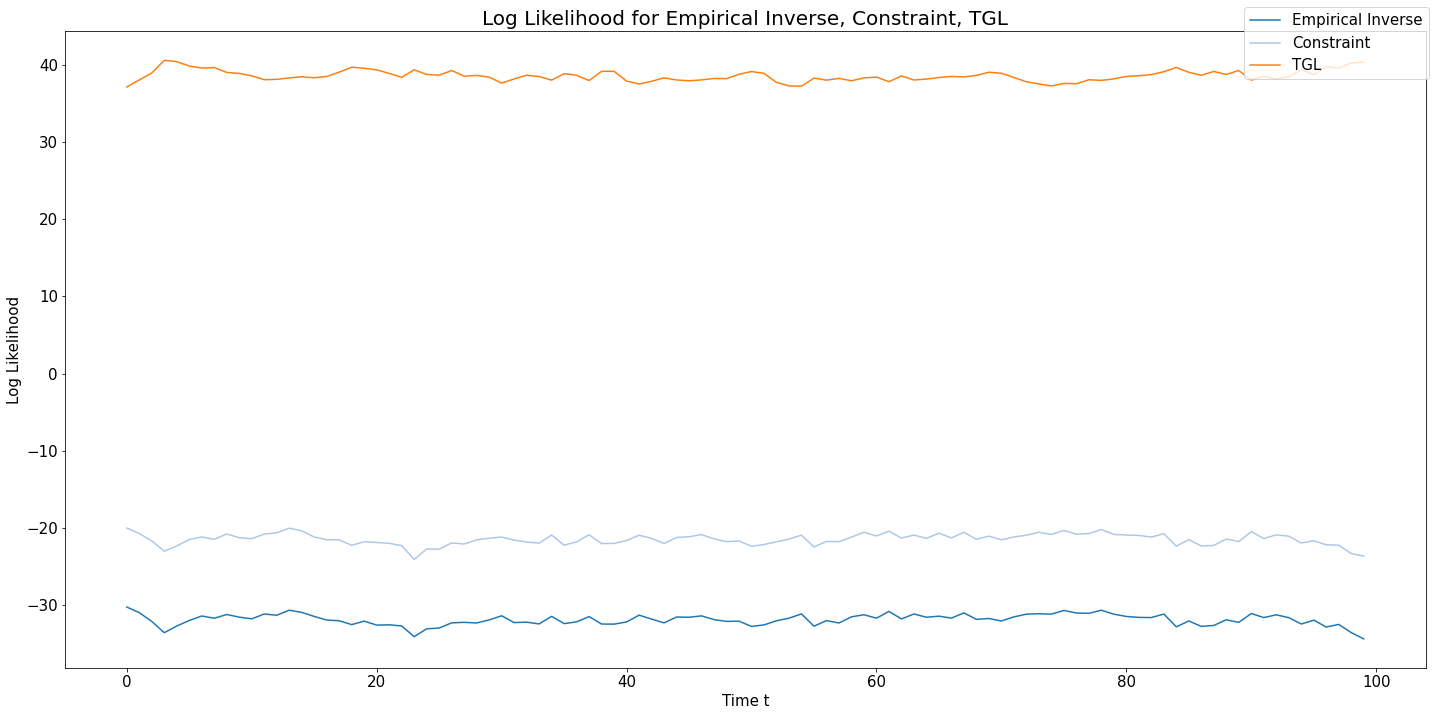

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(n_time), emp_inv_score, label=r'Empirical Inverse')
ax.plot(range(n_time), baseline_score, label=r'Constraint')
ax.plot(range(n_time), fit_score, label=r'TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Log Likelihood for Empirical Inverse, Constraint, TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_like_{}_{}.pdf'.format(dim_X, dim_fac))

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(n_time), emp_inv_score, label=r'Empirical Inverse')
ax.plot(range(n_time), baseline_score, label=r'Constraint')
ax.plot(range(n_time), fit_score, label=r'TGL')

fig.legend(fontsize=15)
ax.set_ylabel('DTrace Loss', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'DTrace Loss for Empirical Inverse, Constraint, TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_like_{}_{}.pdf'.format(dim_X, dim_fac))

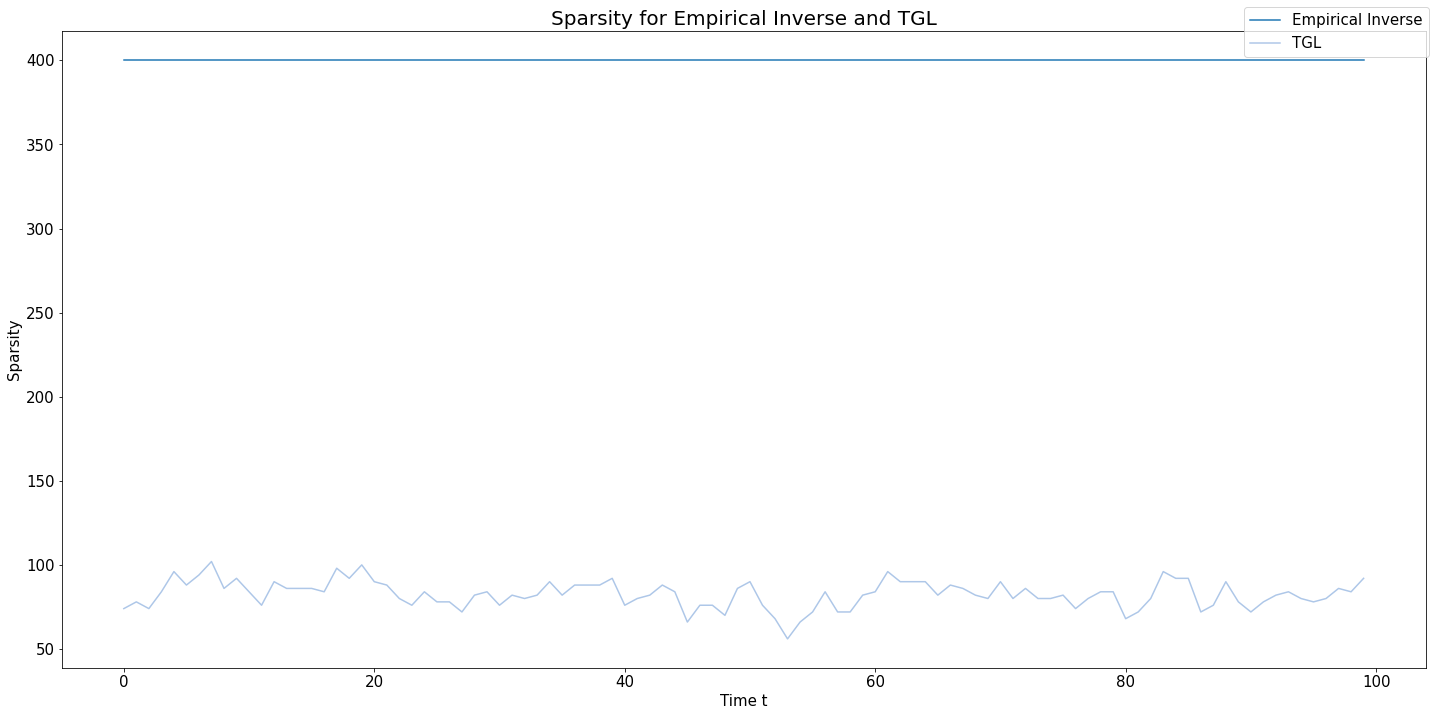

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0

ax.plot(range(n_time), [sum(sum(abs(tgl.emp_inv[k]) > 0)) for k in range(n_time)], label=r'Empirical Inverse')
ax.plot(range(n_time), [sum(sum(abs(pre[k]) > 0)) for k in range(n_time)], label=r'TGL')

fig.legend(fontsize=15)
ax.set_ylabel('Sparsity', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Sparsity for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_supp_{}_{}.pdf'.format(dim_X, dim_fac))

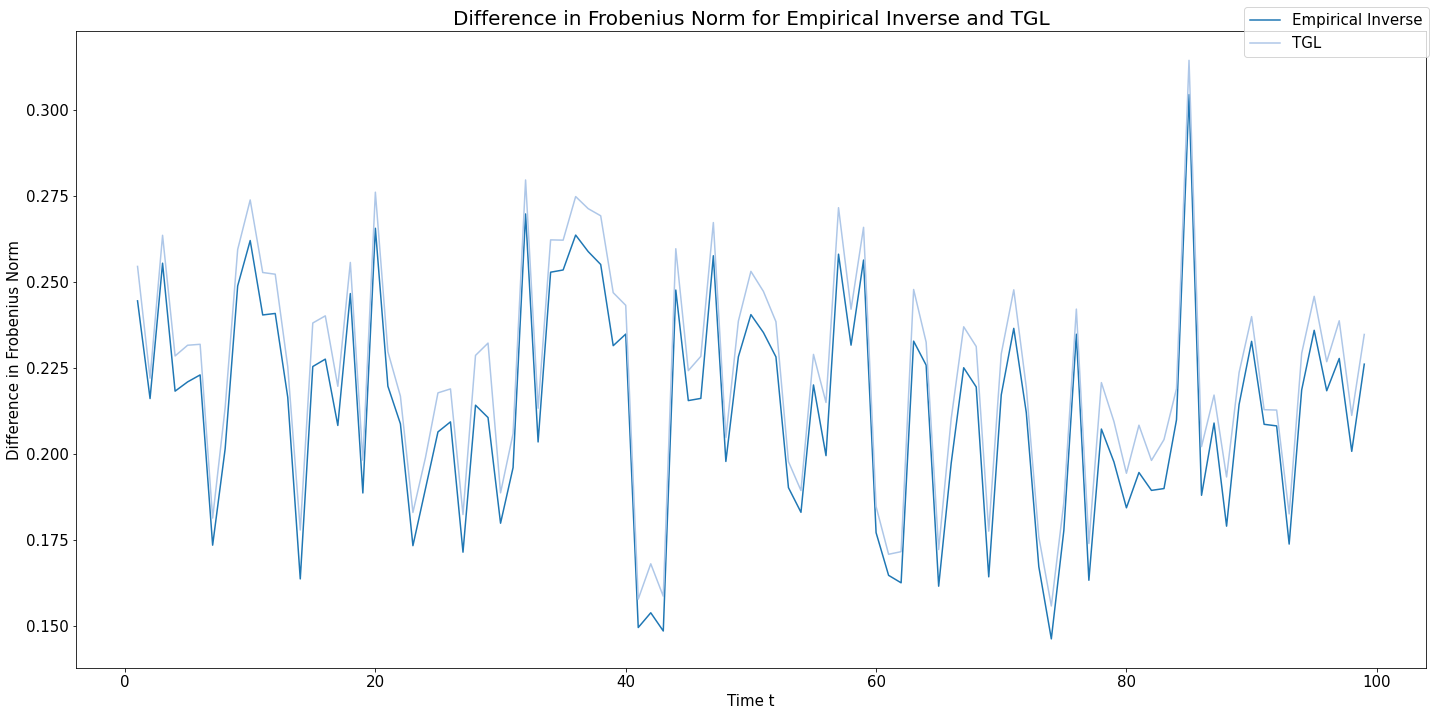

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
# colors = "bgrcmykw"
# color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

diff_fit = [norm(pre[k] - pre[k-1], 'fro') for k in range(1, 100)]
diff_emp = [norm(tgl.emp_inv[k] - tgl.emp_inv[k-1], 'fro') for k in range(1, 100)]
ax.plot(range(1, n_time), np.array(diff_fit), alpha=1, label=r'Empirical Inverse')
ax.plot(range(1, n_time), np.array(diff_emp), alpha=1, label=r'TGL')

        
fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse and TGL', fontsize=20)
plt.tight_layout()
# plt.savefig('diff_fro_{}_{}.pdf'.format(dim_X, dim_fac))